# Phip-Seq Python fold analysis

Here, we are trying to replicate the analysis done in `PhiP_seq_analysis_CIS.Rmd`, in python. This is fold enrichment analysis. The general idea is that you are given a counts 2-D array where the columns are the  

Generally, the code here could serve as the discussion point for more robust code that will help us deal with and do interersting stuff to the data obtained from phip-seq experiments.

## input data
This is a good point of discussion - but moving forward I imagine we might have an easier time splitting the data from experiments into three tables: The counts table, the peptide metadata, and sample metadata. So I'm going to do it for this analysis to test it out.

In [1]:
from phip_data import *
%matplotlib inline

# Set some constants
DD = "../empirical_data"
COUNTS = "sample_peptide_counts.csv"
PMETA= "peptide_metadata.csv"
SMETA= "sample_metadata.csv"
OUTDIR="./fold_analysis_output"

# the following two could (and should) be extracted from sample metadata
# once we determine a standardized format.
# Beads only sample is the mock IP
beads_only_sample = "35"
# The library_control is the pure abundance of phage in library sample
library_control_sample = "37.input"
corr_thresh = 0.9

Here, we read in the raw alignment count files, and take a look the DataFrames produced

In [2]:
out_dir = os.path.join(DD,OUTDIR)
raw_counts = os.path.join(DD,COUNTS)
peptide_metadata = os.path.join(DD,PMETA)
sample_metadata = os.path.join(DD,SMETA)
# TODO extract this from sample metadata.

if not os.path.exists(out_dir): os.mkdir(out_dir) 

# TODO just make a function which returns all raw_counts and metadata 
# after error checking the input
raw_counts = pd.read_csv(raw_counts, header=0, index_col=0)
peptide_metadata = pd.read_csv(peptide_metadata, header=0, index_col=0)
sample_metadata = pd.read_csv(sample_metadata, header=0, index_col=0)

print(f"Raw counts DataFrame: \n\n {raw_counts.head()} \n\n")
print(f"Peptide metadata DataFrame: \n\n {peptide_metadata.head()} \n\n")
print(f"Sample metadata DataFrame: \n\n{sample_metadata.head()} \n\n")

Raw counts DataFrame: 

       1.1  1.2  10.1  10.2  11.1  11.2  12.1  12.2  13.1  13.2  ...  5.1  5.2  \
id                                                              ...             
1     102   12    61    74     7   132     4   380    79    51  ...   19  337   
10    106  229   183   352    81   777     0   122   310   112  ...  498  598   
195   106  229   183   352    81   777     0   122   310   112  ...  498  598   
100    54   63    73    15     8    97     6   213    60    94  ...   38    8   
1001    0    0    10    75     0     9     0     0     0     0  ...    2    0   

      6.1  6.2  7.1  7.2  8.1  8.2  9.1  9.2  
id                                            
1      53   13  210  484   70   77  189  484  
10     24  103  232  128   71  206  128  312  
195    24  103  232  128   71  206  128  312  
100    12   94   55  287   55   83  113  198  
1001    1    2   22    8    3    7    4   12  

[5 rows x 73 columns] 


Peptide metadata DataFrame: 

                  Viru

In [3]:
# Make sure we have the same indexing going on here.
assert(set(raw_counts.index) == set(peptide_metadata.index))

# Now we need to look at correlation between the technical replicates,
# first determine the replicates.
#technical_rep_1, technical_rep_2 = extract_sample_info(raw_counts)

# TODO there's certainly a cleaner way to do this.
technical_rep_1 = [re.match("\d+\.[1]",f"{sample_rep}")[0] 
for sample_rep in raw_counts.columns 
    if re.match("\d+\.[1]",f"{sample_rep}") != None]

technical_rep_2 = [re.match("\d+\.[2]",f"{sample_rep}")[0] 
for sample_rep in raw_counts.columns 
    if re.match("\d+\.[2]",f"{sample_rep}") != None]

In [4]:
pruned_counts = raw_counts.copy()
correlations, samples = [], []
for i, (t1, t2) in enumerate(zip(technical_rep_1, technical_rep_2)):
        
    # let's make sure we're looking at the same sample
    assert(t1.split(".")[0] == t2.split(".")[0])
    sample = t1.split(".")[0]

    # Now, lets determine which samples to drop,
    # and which samples we can sum replicates over
    # based off of correlation.
    corr = st.pearsonr(pruned_counts[t1], pruned_counts[t2])
    correlations.append(corr)
    samples.append(sample)
            
    # if the technical replicates are correlated enough then
    # sum the pruned_counts, add 10, and insert new column.
    #print(f"sample {sample} has technical rep correlation: {corr[0]} \
    #    with a p-value of {round(corr[1],5)}")
    if (corr[0] > corr_thresh and corr[1] <= 0.5) or sample == beads_only_sample:
        pruned_counts[sample] = pruned_counts[t1] + pruned_counts[t2] + 20
    else:
        print(f"dropping sample {sample}, b/c corr was: {corr[0]}")

    pruned_counts.drop([t1,t2], axis=1, inplace=True)

dropping sample 12, b/c corr was: 0.850798384205189
dropping sample 13, b/c corr was: 0.8994241241443361
dropping sample 15, b/c corr was: 0.6109882519924675
dropping sample 28, b/c corr was: 0.31642563112379596
dropping sample 36, b/c corr was: 0.8596125139113189


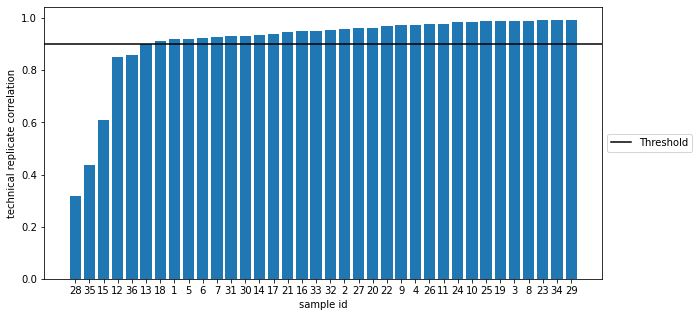

In [5]:
fig, ax = plt.subplots(figsize=(13, 10))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)

correlations = [c[0] for c in correlations]
samples = [x for _,x in sorted(zip(correlations,samples))]
ax.bar(samples, sorted(correlations))
ax.axhline(y=corr_thresh, color="black", label = "Threshold")
ax.set_ylabel(f"technical replicate correlation")
ax.set_xlabel(f"sample id")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(10,5)
#fig.savefig(os.path.join(out_dir,"technical_replicates_correlation.pdf"))
plt.show()

**Seems** to agree peferctly with the r analysis

## Conflict w/ R 

The standardized_enrichment python computation of the counts matrix in the cell below produces *slightly* different results (We could do some simple summary stats to analyze the full extend of the difference) from that in `PhiP_seq_analysis_CIS.Rmd`. I'm hoping someone with more R experience could chime in on why. From what I can tell, it seems like the R code has more floating point precision than the operations on `float64` pandas dataframes. 

The python code looks like this:

In [6]:
frequencies = pruned_counts.truediv(pruned_counts.sum(axis=0), axis=1)
enrichment = frequencies.truediv(frequencies[library_control_sample], axis=0)
standardized_enrichment = enrichment.subtract(enrichment[beads_only_sample], axis=0)

The R code looks like this:

```
#read in file with summed counts. **Note: a pseudocount of 10 has been applied across the entire dataset.
count_data_pseudo <- read_csv("../empirical_data/cstoddar_allSamps_redundant_annotated_MODpseudo_summed_reps.csv")

#sum all the columns except first four
col_sums=apply((count_data_pseudo[,-c(1:4)]), 2, sum)

#divide each count by the column sum to determine frequency
freq=cbind(count_data_pseudo[,1:4],(sweep((count_data_pseudo[,-c(1:4)]), 2, col_sums, "/")))

#divide frequency by normalized input to determine fold-enrichment (note that we manually changed the code to specify input data column)
enrichment=cbind(count_data_pseudo[,1:4],(sweep(freq[,-c(1:4)], 1, freq$X37.input, "/")))

#subtract out background enrichment; here, the beads_only_sum is also subtracted from the Input and Beads_only_sum. However, we have already used these values to establish enrichment so we are fine to proceed with this analysis. Manually copied one replicate (for now) of beads-only samples into code

standardized_enrichment=cbind(count_data_pseudo[,1:4],(sweep(enrichment[,-c(1:4)], 1, enrichment$X35, "-")))
#print(standardized_enrichment)

write.csv(standardized_enrichment,"20200325_standardized_enrichment_summed_reps.csv")
```

**Hoping** someone can help tell me why my code produces slightly different results.

Now, lets read in the R standardized enrichment and take a look at the difference.

In [7]:
r_standardized_enrichment = pd.read_csv(
    "../empirical_data/20200325_standardized_enrichment_summed_reps.csv",
    header = 0,
    index_col = 0)

samp1_p = standardized_enrichment["1"]
samp1_r = r_standardized_enrichment["X1"]

print(f"First five enrichments of sample 1 Python Standardized enrichment : \n\n{samp1_p.head()}\n\n\First five enrichments of sample 1  R Standardized enrichment : \n\n{samp1_r.head()}\n\n")

First five enrichments of sample 1 Python Standardized enrichment : 

id
1       0.248197
10      0.136208
195     0.136208
100    -1.665878
1001   -0.311110
Name: 1, dtype: float64

\First five enrichments of sample 1  R Standardized enrichment : 

1    0.251551
2    0.138677
3    0.138677
4   -1.679056
5   -0.293720
Name: X1, dtype: float64




### Python Results. 

Still looks like we get a few interesting (looking) results! First we choose some samples, and specific virus strains we would like to see enrichment for as a function of tile rank ("genomic location"). The following list represents the list of all possible virus strains and samples

In [8]:
#all_strains = set(peptide_metadata["Virus_Strain"])
#all_samples = standardized_enrichment.columns[1:]
#print(f"All strains in dataset : \n\n{all_strains}\n\n All samples in dataset : \n\n{all_samples}\n\n")
! cat ../empirical_data/peptide_metadata.csv | cut -d ',' -f 2 | sort | uniq | sort 

CHIKV_KPA15_NS
CHIKV_KPA15_S
CHIKV_TR206-H804187_NS
CHIKV_TR206-H804187_S
DENV1_Myanmar1996
DENV1_WesternPacific
DENV2_16803
DENV2_BR-BID-V3653-2008
DENV2_BurkinaFaso1983
DENV2_NewGuineaC
DENV3_BR-BID-V2403-2008
DENV3_Mozambique1985
DENV4_H781363
DENV4_P73_1120
DENV4_SJRP-850-2013
HIV_Env_BF520_W14_C2
HIV_Env_BG505_W6_C2
HIV_Env_CladeA1
HIV_Env_CladeA2
HIV_Env_CladeB
HIV_Env_CladeC
HIV_Env_CladeD
HIV_Env_Q23
HIV_Env_Q461_d1
HIV_Env_QA013_385M_ENV_R3
HIV_Env_QA013_70I_ENV_H1
HIV_Env_QB850_632p_B10
HIV_Env_QB850_72p_C14_A1
HIV_Env_QC406_F3
HIV_Gag_CladeA1
HIV_Gag_CladeA2
HIV_Gag_CladeB
HIV_Gag_CladeC
HIV_Gag_CladeD
HIV_Gag_Q23
HIV_Nef_CladeA
HIV_Nef_CladeB
HIV_Nef_CladeC
HIV_Nef_CladeD
HIV_Nef_Q23
HIV_Pol_CladeA1
HIV_Pol_CladeA2
HIV_Pol_CladeB
HIV_Pol_CladeC
HIV_Pol_CladeD
HIV_Pol_Q23
HIV_Rev_CladeA1
HIV_Rev_CladeA2
HIV_Rev_CladeB
HIV_Rev_CladeC
HIV_Rev_CladeD
HIV_Rev_Q23
HIV_Tat_CladeA1
HIV_Tat_CladeA2
HIV_Tat_CladeB
HIV_Tat_CladeC
HIV_Tat_CladeD
HIV_Tat_Q23
HIV_Vif_CladeA
HIV_Vif_Clade

Now we select analysis to run, and query our data. Here, we want to isolate the indices for the _virus strain_ of interest, and plot those tiles and their respective standardized enrichment for an individual. This is plotted as a funtion of tile position across the viral genome. Hopefully, we might see cross-reactivity between some strains for a sample of interest (similar bumps on the lines, I suppose). 

In [9]:
# choose a pattern for virus to compare.

strain_pattern = "HIV.+"
#strain_pattern = "HIV_Gag.+"
#strain_pattern = "DENV.+"
#strain_pattern = "ZIKV.+"

all_strains = set(peptide_metadata["Virus_Strain"])
selected_strains = [re.match(strain_pattern,f"{strain}")[0] 
    for strain in all_strains 
    if re.match(strain_pattern,f"{strain}") != None]

# or choose some strains explicitly

#selected_strains = ["ZIKV_HPF2013", "ZIKV_PRVABC59"]
#selected_strains = ["HIV_Env_BF520_W14_C2", "HIV_Env_BG505_W6_C2"]

# choose some samples

# samples = ["11"]
# samples = standardized_enrichment.columns[1:]
samples = [str(x) for x in list(range(25,28))]

print(f"making individual plots for samples:\n\n {samples}\n\n comparing virus strains:\n\n {selected_strains} \n\n ")

making individual plots for samples:

 ['25', '26', '27']

 comparing virus strains:

 ['HIV_Pol_CladeC', 'HIV_Tat_CladeD', 'HIV_Vif_CladeC', 'HIV_Gag_CladeA1', 'HIV_Pol_CladeD', 'HIV_vpu_CladeC', 'HIV_Env_CladeA2', 'HIV_Pol_CladeA1', 'HIV_Tat_CladeB', 'HIV_Nef_CladeD', 'HIV_Tat_CladeC', 'HIV_Rev_CladeC', 'HIV_Rev_Q23', 'HIV_Env_QB850_72p_C14_A1', 'HIV_Rev_CladeD', 'HIV_vpr_CladeA', 'HIV_Vif_CladeA', 'HIV_Tat_CladeA1', 'HIV_Tat_CladeA2', 'HIV_Nef_CladeC', 'HIV_vpu_CladeA', 'HIV_Env_Q23', 'HIV_Nef_CladeB', 'HIV_Pol_CladeB', 'HIV_Env_CladeB', 'HIV_Nef_Q23', 'HIV_Vpr_Q23', 'HIV_vpr_CladeD', 'HIV_Rev_CladeA1', 'HIV_Env_QA013_385M_ENV_R3', 'HIV_Rev_CladeB', 'HIV_Vif_CladeB', 'HIV_Vpu_Q23', 'HIV_Gag_CladeB', 'HIV_vpu_CladeD', 'HIV_Tat_Q23', 'HIV_Env_Q461_d1', 'HIV_Env_CladeC', 'HIV_Gag_CladeC', 'HIV_Env_CladeA1', 'HIV_Env_BF520_W14_C2', 'HIV_Vif_CladeD', 'HIV_Pol_Q23', 'HIV_vpr_CladeB', 'HIV_vpu_CladeB', 'HIV_Env_QA013_70I_ENV_H1', 'HIV_Env_QC406_F3', 'HIV_Gag_CladeA2', 'HIV_Env_QB850_632p_B

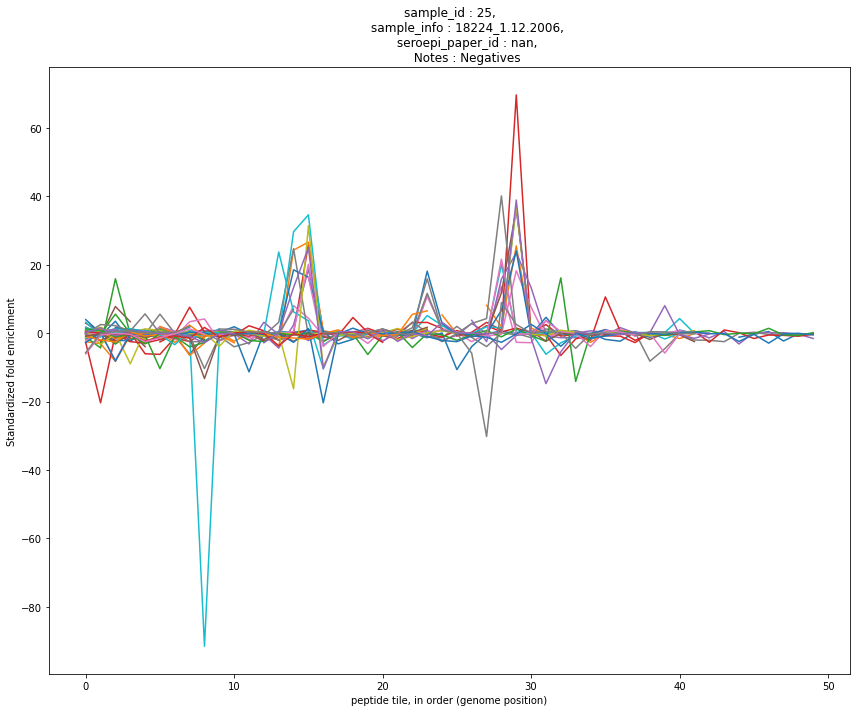

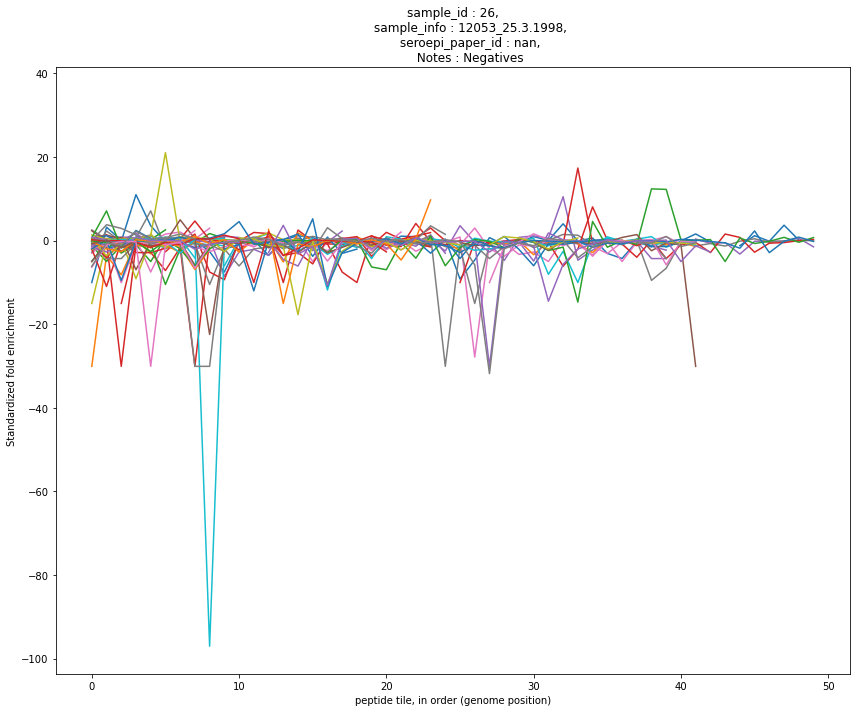

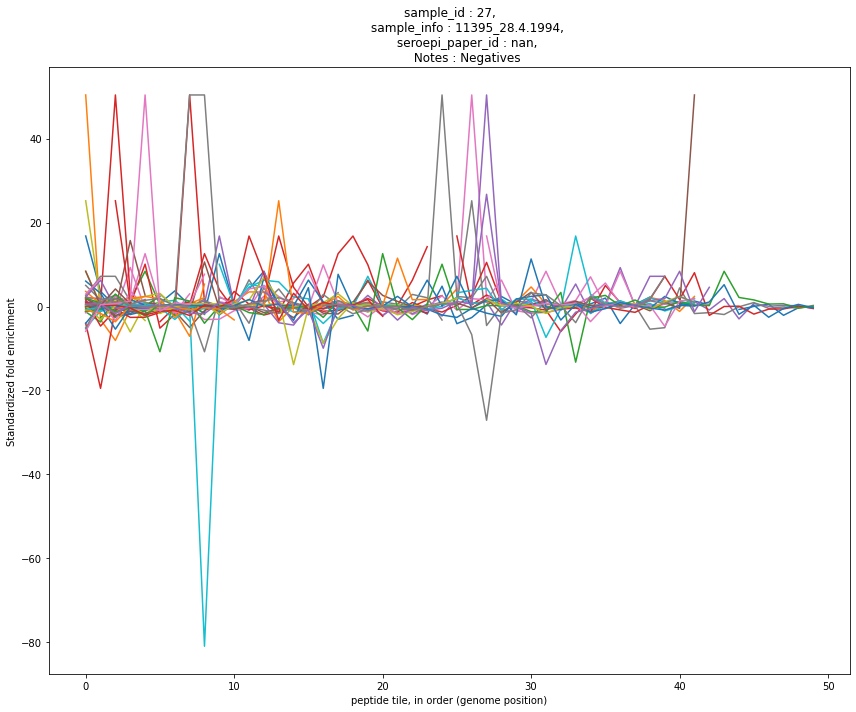

In [10]:
# make a seperate plot for each sample
for sample in samples:
    if sample == library_control_sample: continue
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    for strain in selected_strains:
        strain_indices = peptide_metadata[peptide_metadata["Virus_Strain"] == strain].index
        ax.plot(list(range(len(strain_indices))),
                standardized_enrichment[sample][strain_indices],
                label = strain)
    
    # TODO : we should make these strings, or the the 
    # header for counts data integers ... ?
    sample = int(sample)
    
    sample_info = sample_metadata["sample_info"][sample]
    seroepi_paper_id = sample_metadata["seroepi_paper_id"][sample]
    notes = sample_metadata["Notes"][sample]
    ax.set_title(
        f"sample_id : {sample},\n \
        sample_info : {sample_info},\n \
        seroepi_paper_id : {seroepi_paper_id},\n \
        Notes : {notes}")
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel(f"Standardized fold enrichment")
    ax.set_xlabel(f"peptide tile, in order (genome position)")
    plt.tight_layout()
    fig.savefig(f"../Attic/fold_enrichment_{sample}.pdf")
    plt.show()

## Some stuff to keep in mind?

I noticed that some strains, specifically for Zika, we _highly_ correlated. This is most likely due to ambiguous peptide sequences which belong to multiple to virus strains. Notice there is a slight offset and little correlations near the end. I'm still pretty confused about the offset ... 

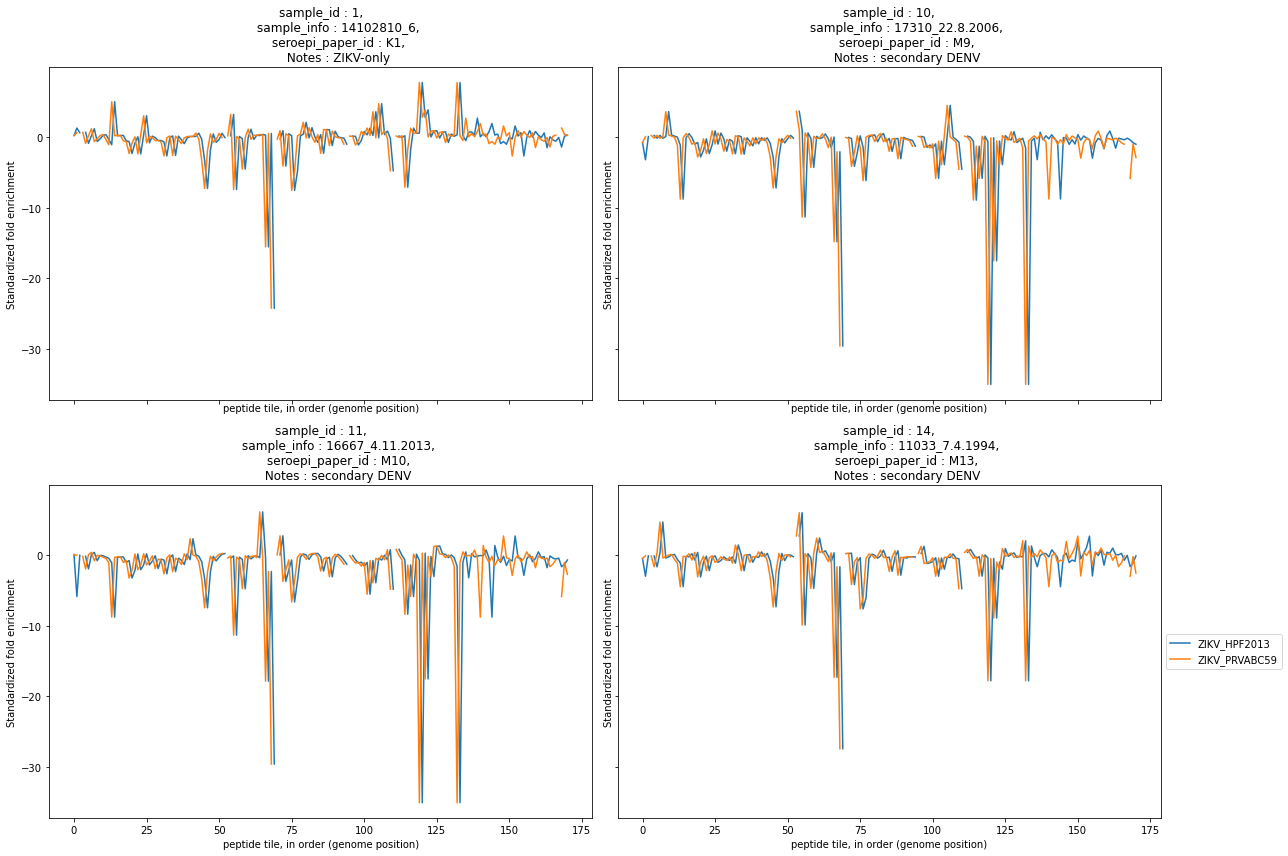

In [11]:
#strain_pattern = "HIV_Gag.+"
#strain_pattern = "DENV.+"
#strain_pattern = "ZIKV.+"

# samples to look at, this could also be done 
# by querying the sample metadata or listed manually
samples = standardized_enrichment.columns
all_strains = set(peptide_metadata["Virus_Strain"])
selected_strains = [re.match(strain_pattern,f"{strain}")[0] 
    for strain in all_strains 
    if re.match(strain_pattern,f"{strain}") != None]

selected_strains = ["ZIKV_HPF2013", "ZIKV_PRVABC59"]
#selected_strains = ["HIV_Env_BF520_W14_C2", "HIV_Env_BG505_W6_C2"]

fig, ax = plt.subplots(2,2,figsize=(18, 12),sharex=True,sharey=True)
for i, sample in enumerate(samples[1:5]):
    if sample == library_control_sample: continue
    row = i // 2
    column = i % 2
    for strain in selected_strains:
        strain_index = peptide_metadata[peptide_metadata["Virus_Strain"] == strain].index
        ax[row][column].plot(list(range(len(strain_index))),
                standardized_enrichment[sample][strain_index],
                label = strain)
    
    # TODO : we should make these strings, or the the 
    # header for counts data integers ... ?
    sample = int(sample)
    
    sample_info = sample_metadata["sample_info"][sample]
    seroepi_paper_id = sample_metadata["seroepi_paper_id"][sample]
    notes = sample_metadata["Notes"][sample]
    ax[row][column].set_title(
        f"sample_id : {sample},\n \
        sample_info : {sample_info},\n \
        seroepi_paper_id : {seroepi_paper_id},\n \
        Notes : {notes}")

    ax[row][column].set_ylabel(f"Standardized fold enrichment")
    ax[row][column].set_xlabel(f"peptide tile, in order (genome position)")
ax[1][1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
fig.savefig(f"../Attic/fold_enrichment_1.pdf")
    



